In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/classes.json
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_002.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_006.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_005.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_003.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_004.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_007.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/Tile 7/images/image_part_009.jpg
/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/

In [2]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.math import log , reduce_mean
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
!pip install patchify
from patchify import patchify

In [4]:
root_directory = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset/"
patch_size = 256

In [5]:
scaler = MinMaxScaler()

In [6]:
image_dataset = []
for path,subdirs,files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = os.listdir(path)
        images.sort()
#         print(images)
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):
                #Get image paths  "print(path+"/"+image_name)"
                
                image = cv2.imread(path+"/"+image_name,1)
                SIZE_X = (image.shape[1]//patch_size)*patch_size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0,0,SIZE_X,SIZE_Y))
                image = np.array(image)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):  
                        single_patch_img = patches_img[i,j,0,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        image_dataset.append(single_patch_img)

In [7]:
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = os.listdir(path)
        masks.sort()
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):
                
                mask = cv2.imread(path+'/'+mask_name, 1)
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0,0,SIZE_X,SIZE_Y))
                mask = np.array(mask)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)
                
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):  
                        single_patch_mask = patches_mask[i,j,0,:,:]
                        mask_dataset.append(single_patch_mask)


In [8]:
image_dataset = np.array(image_dataset[:400])
mask_dataset =  np.array(mask_dataset[:400])

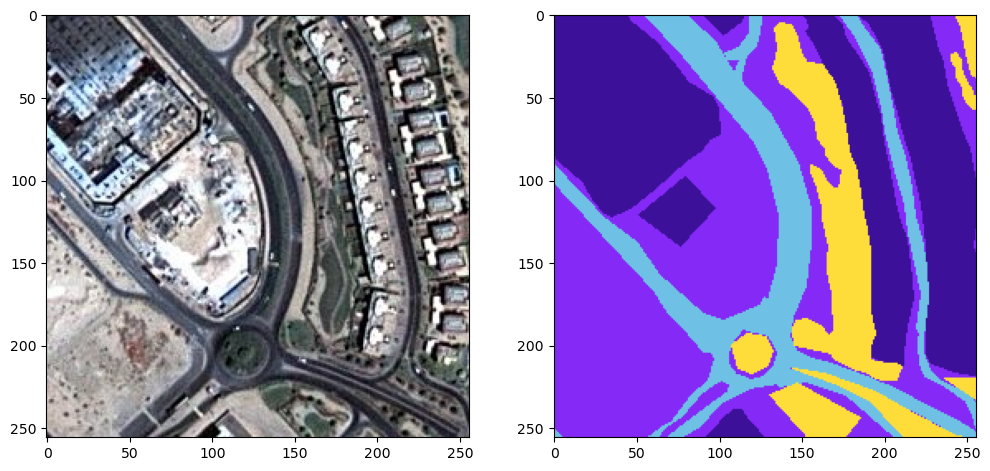

In [9]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [10]:
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [11]:
label = single_patch_mask

def rgb_to_2D_label(label):
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg [np.all(label == Unlabeled, axis = -1)] = 0
    label_seg [np.all(label == Land, axis = -1)] = 0
    label_seg [np.all(label == Road, axis = -1)] = 1  
    label_seg [np.all(label == Vegetation, axis = -1)] = 0   
    label_seg [np.all(label == Water, axis = -1)] = 0
    label_seg [np.all(label == Building, axis = -1)] = 2
    
    label_seg = label_seg[:,:,0]
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

In [12]:
labels = np.array(labels)
labels.shape

(400, 256, 256)

In [13]:
labels_cat = to_categorical(labels)
labels_cat.shape

(400, 256, 256, 3)

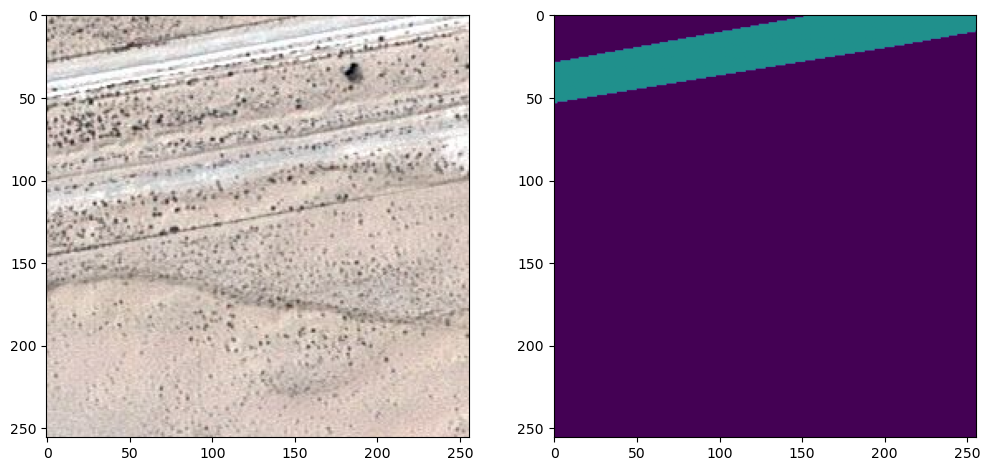

In [14]:
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number], vmin=0, vmax=2)
plt.show()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, train_size = 0.8, test_size = 0.2, random_state = 42)

In [16]:
del image_dataset, mask_dataset, labels_cat, labels

In [17]:
from tensorflow.keras.layers import  Rescaling

In [18]:
def multi_unet_model(input_shape,n_classes):
    # input layer shape is equal to patch image size
    inputs = Input(shape=input_shape)

    # rescale images from (0, 255) to (0, 1)
    rescale = Rescaling(scale=1. / 255, input_shape=(256, 256, 2))(inputs)
    previous_block_activation = rescale  # Set aside residual

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [16,32,64,128]:
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
            previous_block_activation)
        x = Dropout(0.1)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
        previous_block_activation)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5

    # Expansive path: Second half of the network: upsampling inputs
    for f in reversed([16,32,64,128]):
        x = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = concatenate([x, contraction[f'conv{f}']])
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(0.2)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = Conv2D(filters=n_classes, kernel_size=(1, 1), activation="softmax")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)



In [19]:
input_shape = (256, 256, 3)
n_classes = 3  # Assuming you have 2 classes in your classification problem
model = multi_unet_model(input_shape, n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [20]:
def categorical_crossentropy_with_mask(y_true, y_pred):
    y_true = y_true[:,:,:,1:]
    loss_matrix = y_true * -log(y_pred)
    loss = reduce_mean(loss_matrix, axis=(1,2,3)) + 0.001
    return loss
                   
def accuracy_with_mask(y_true, y_pred):
    # will be implemented
    
    y_true = y_true[:,:,:,1:]
    N = y_pred.size
    accuracy = np.sum(y_true == y_pred)/ N

    return 1

In [21]:
model.compile(optimizer='adam', loss=categorical_crossentropy_with_mask)

In [22]:

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import CSVLogger

In [23]:
from tensorflow.keras.metrics import MeanIoU, Accuracy
from tensorflow.keras.metrics import MeanIoU, Accuracy

# Define the IoU metric
iou = MeanIoU(num_classes=n_classes)

In [24]:
accuracy=Accuracy()

model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=['accuracy',iou],run_eagerly=True)

# train and save model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
10/10 [==============================] - 20s 433ms/step - loss: 1.0041 - accuracy: 0.7145 - mean_io_u: 0.3333 - val_loss: 0.9278 - val_accuracy: 0.7521 - val_mean_io_u: 0.3333
Epoch 2/100
10/10 [==============================] - 3s 286ms/step - loss: 0.8547 - accuracy: 0.7803 - mean_io_u: 0.3333 - val_loss: 0.7469 - val_accuracy: 0.7521 - val_mean_io_u: 0.3333
Epoch 3/100
10/10 [==============================] - 3s 330ms/step - loss: 0.7105 - accuracy: 0.7804 - mean_io_u: 0.3333 - val_loss: 0.7349 - val_accuracy: 0.7521 - val_mean_io_u: 0.3333
Epoch 4/100
10/10 [==============================] - 3s 283ms/step - loss: 0.6887 - accuracy: 0.7804 - mean_io_u: 0.3333 - val_loss: 0.7325 - val_accuracy: 0.7521 - val_mean_io_u: 0.3333
Epoch 5/100
10/10 [==============================] - 3s 292ms/step - loss: 0.6877 - accuracy: 0.7804 - mean_io_u: 0.3333 - val_loss: 0.7342 - val_accuracy: 0.7521 - val_mean_io_u: 0.3333
Epoch 6/100
10/10 [==============================] - 3s 284ms/st

1/1 [==============================] - 0s 317ms/step


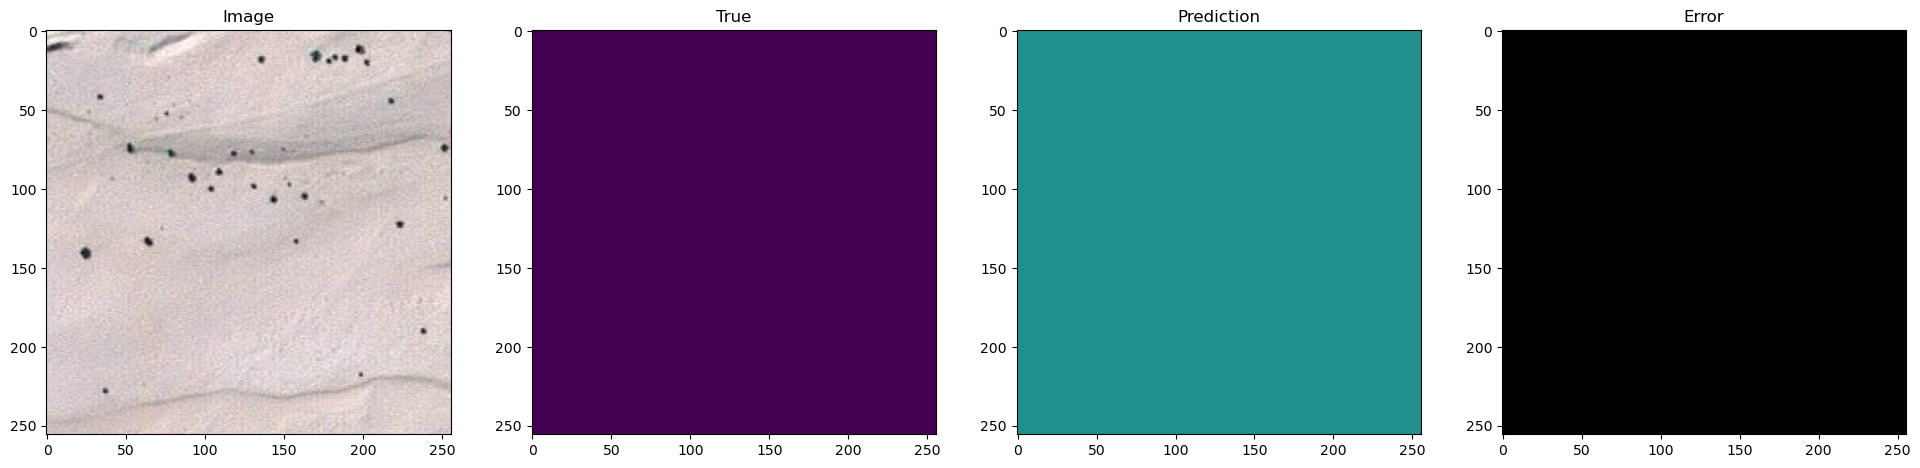

1/1 [==============================] - 0s 45ms/step


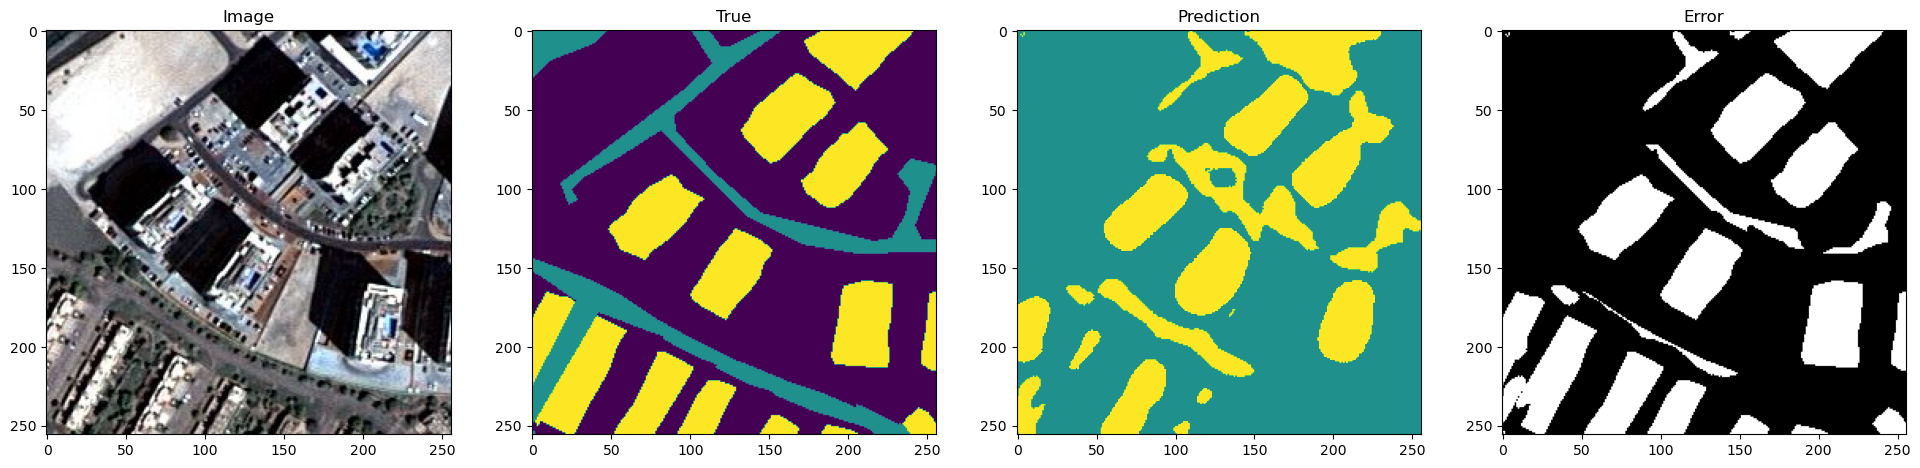

1/1 [==============================] - 0s 45ms/step


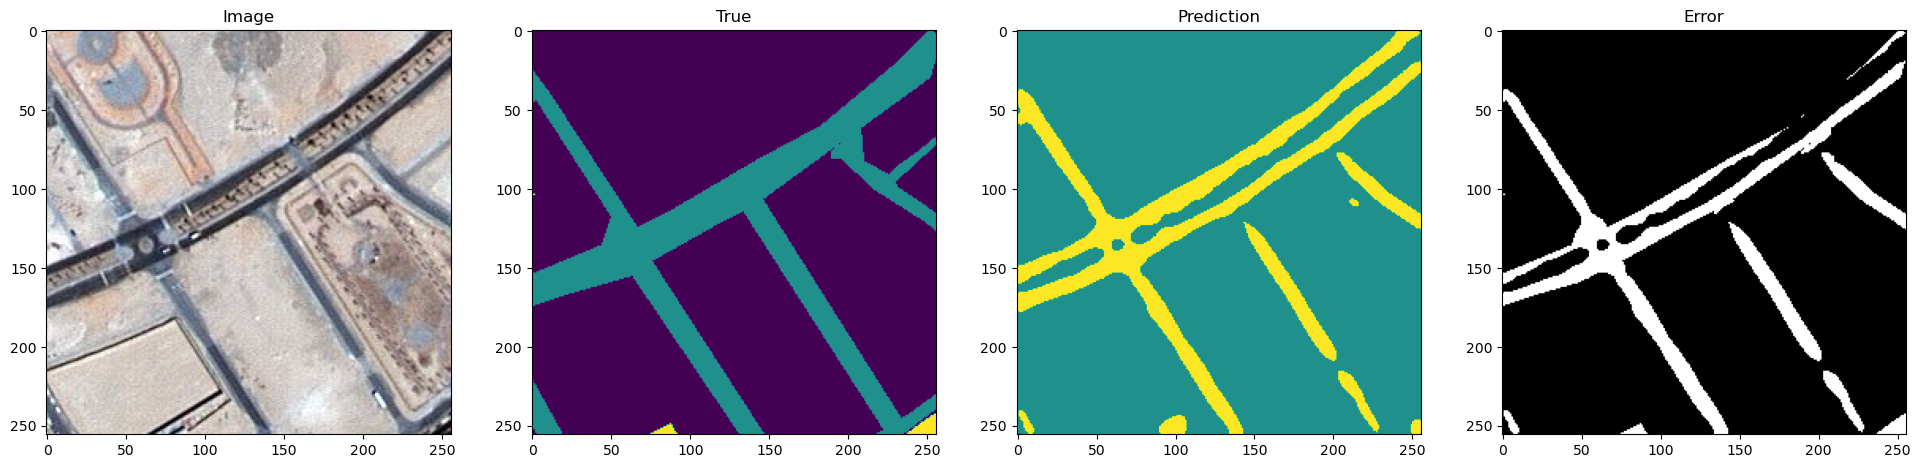

1/1 [==============================] - 0s 50ms/step


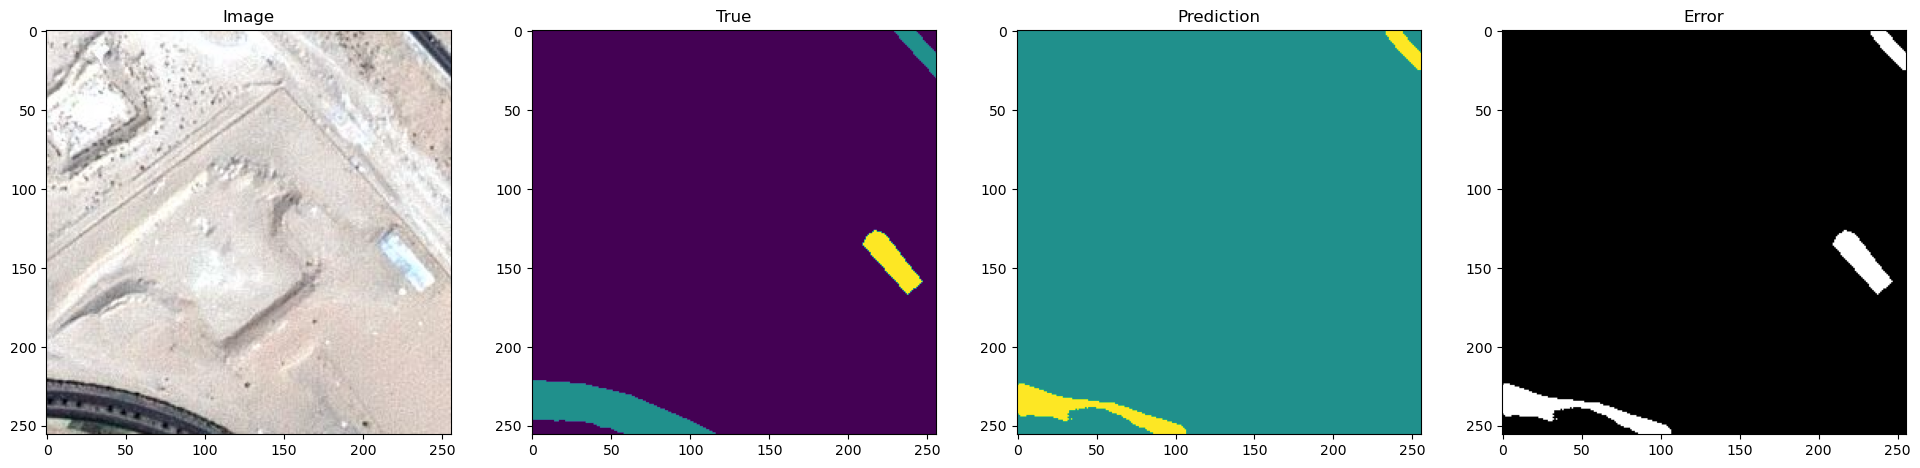

1/1 [==============================] - 0s 48ms/step


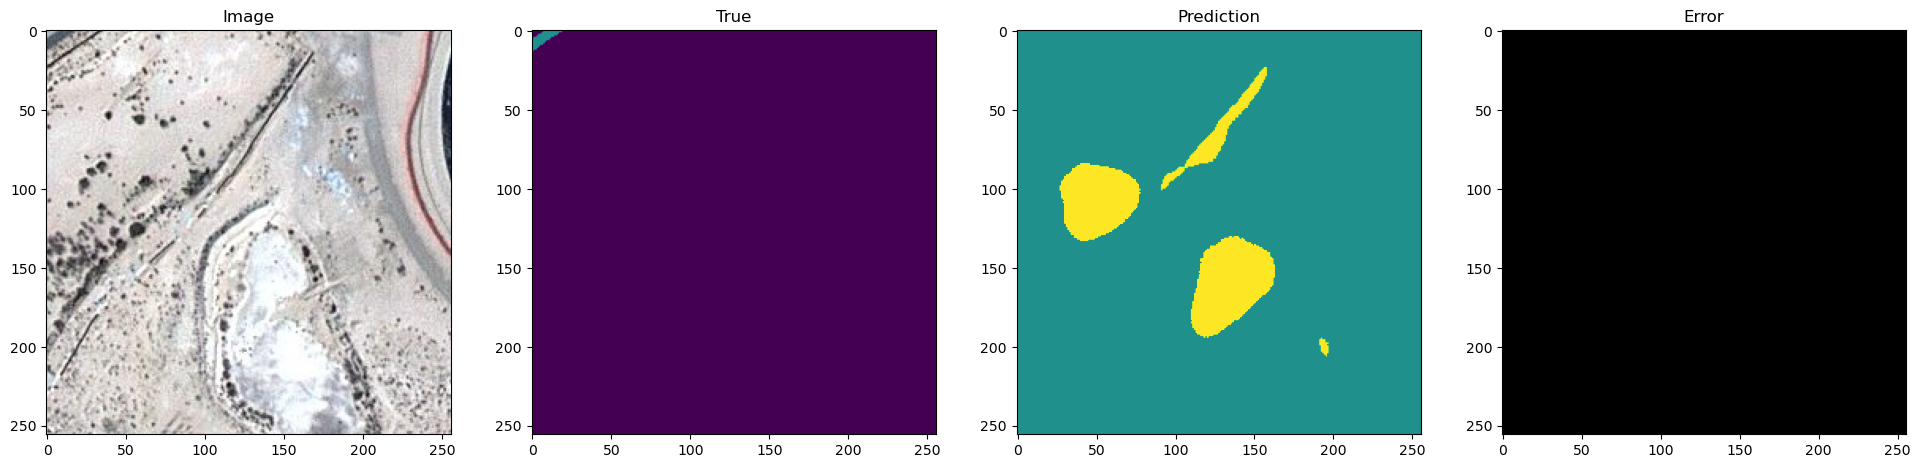

In [25]:
vmin = 0
vmax = 2

for i in range(5):
    
    image_number = random.randint(0, X_test.shape[0])
    
    plt.figure(figsize=(24, 6))
    
    plt.subplot(141)
    plt.title('Image')
    plt.imshow(X_test[image_number])
    
    plt.subplot(142)
    plt.title('True')
    true = y_test[image_number].argmax(axis=2)
    plt.imshow(true, vmin = vmin, vmax = vmax)
    
    plt.subplot(143)
    plt.title('Prediction')
    prediction = model.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2) + 1 # convert to 0-5 classes
    plt.imshow(prediction, vmin = vmin, vmax = vmax)
    
    plt.subplot(144)
    plt.title('Error')
    error = (true != prediction) & (true != 0)
    error = error.astype(int)
    plt.imshow(error, cmap='gray')
    
    plt.show()

In [26]:
loss, iou_score, accuracy_score = model.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("IoU Score:", iou_score)
print("Accuracy:", accuracy_score)

3/3 [==============================] - 0s 80ms/step - loss: 0.6147 - accuracy: 0.8639 - mean_io_u: 0.3896
Test Loss: 0.6147351264953613
IoU Score: 0.8638664484024048
Accuracy: 0.38960471749305725


In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D


In [28]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


94765736/94765736 [==============================] - 5s 0us/step


In [29]:
for layer in resnet.layers:
    layer.trainable = False


In [30]:
resnet_inputs = Input(shape=(256, 256, 3))
resnet_outputs = resnet(resnet_inputs)


In [31]:
resnet_outputs = GlobalAveragePooling2D()(resnet_outputs)


In [32]:
def multi_wnet_model1(input_shape,n_classes):
    # input layer shape is equal to patch image size
    inputs = Input(shape=input_shape)

    # rescale images from (0, 255) to (0, 1)
    rescale = Rescaling(scale=1. / 255)(inputs)
    previous_block_activation = rescale

    # Add the ResNet model
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in resnet.layers:
        layer.trainable = False
    resnet_outputs = resnet(previous_block_activation)


    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [16,32,64,128]:
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
            previous_block_activation)
        x = Dropout(0.1)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
        previous_block_activation)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5

    # Expansive path: Second half of the network: upsampling inputs
    for f in reversed([16,32,64,128]):
        x = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = concatenate([x, contraction[f'conv{f}']])
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(0.2)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x
        
    for f in [16,32,64,128]:
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
            previous_block_activation)
        x = Dropout(0.1)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = MaxPooling2D((2, 2))(x)
        previous_block_activation = x
        
    c10 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
        previous_block_activation)
    c10 = Dropout(0.2)(c10)
    c10 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c10
    c11 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(
        previous_block_activation)
    c11 = Dropout(0.2)(c11)
    c11 = Conv2D(160, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c11
    for f in reversed([16,32,64,128]):
        x = Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = concatenate([x, contraction[f'conv{f}']])
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(0.2)(x)
        x = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in resnet.layers:
        layer.trainable = False
    resnet_outputs = resnet(previous_block_activation)

    # Add a global average pooling layer after the ResNet model
    resnet_outputs = GlobalAveragePooling2D()(resnet_outputs)

    # Concatenate the outputs from the previous block and the ResNet model
    merged_outputs = concatenate([previous_block_activation, resnet_outputs])

    # Add a final convolutional layer for refinement
    outputs = Conv2D(filters=n_classes, kernel_size=(1, 1), activation="softmax")(merged_outputs)

    return Model(inputs=inputs, outputs=outputs)

In [33]:
model.compile(optimizer='adam', loss=categorical_crossentropy_with_mask)

In [34]:
from tensorflow.keras.metrics import MeanIoU, Accuracy

# Define the IoU metric
iou = MeanIoU(num_classes=n_classes)

In [35]:

accuracys = Accuracy()
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=['accuracy',iou,],run_eagerly=True)

# train and save model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
10/10 [==============================] - 9s 301ms/step - loss: 0.2646 - accuracy: 0.9073 - mean_io_u_1: 0.3484 - val_loss: 0.3976 - val_accuracy: 0.8547 - val_mean_io_u_1: 0.3333
Epoch 2/100
10/10 [==============================] - 3s 285ms/step - loss: 0.1838 - accuracy: 0.9311 - mean_io_u_1: 0.3374 - val_loss: 0.5389 - val_accuracy: 0.8615 - val_mean_io_u_1: 0.3363
Epoch 3/100
10/10 [==============================] - 3s 283ms/step - loss: 0.1399 - accuracy: 0.9443 - mean_io_u_1: 0.3508 - val_loss: 0.5585 - val_accuracy: 0.8646 - val_mean_io_u_1: 0.3508
Epoch 4/100
10/10 [==============================] - 3s 281ms/step - loss: 0.1184 - accuracy: 0.9528 - mean_io_u_1: 0.3808 - val_loss: 0.6057 - val_accuracy: 0.8638 - val_mean_io_u_1: 0.3928
Epoch 5/100
10/10 [==============================] - 3s 280ms/step - loss: 0.1094 - accuracy: 0.9556 - mean_io_u_1: 0.4051 - val_loss: 0.6274 - val_accuracy: 0.8646 - val_mean_io_u_1: 0.4013
Epoch 6/100
10/10 [==========================

1/1 [==============================] - 0s 45ms/step


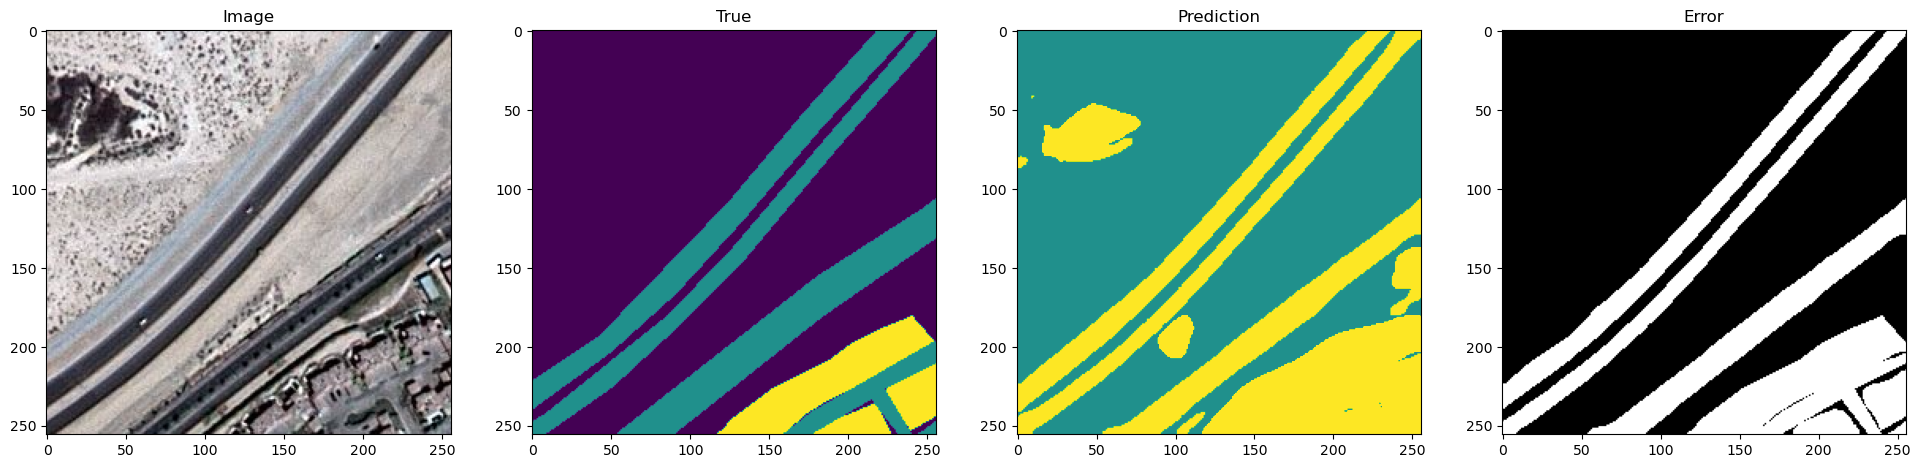

1/1 [==============================] - 0s 46ms/step


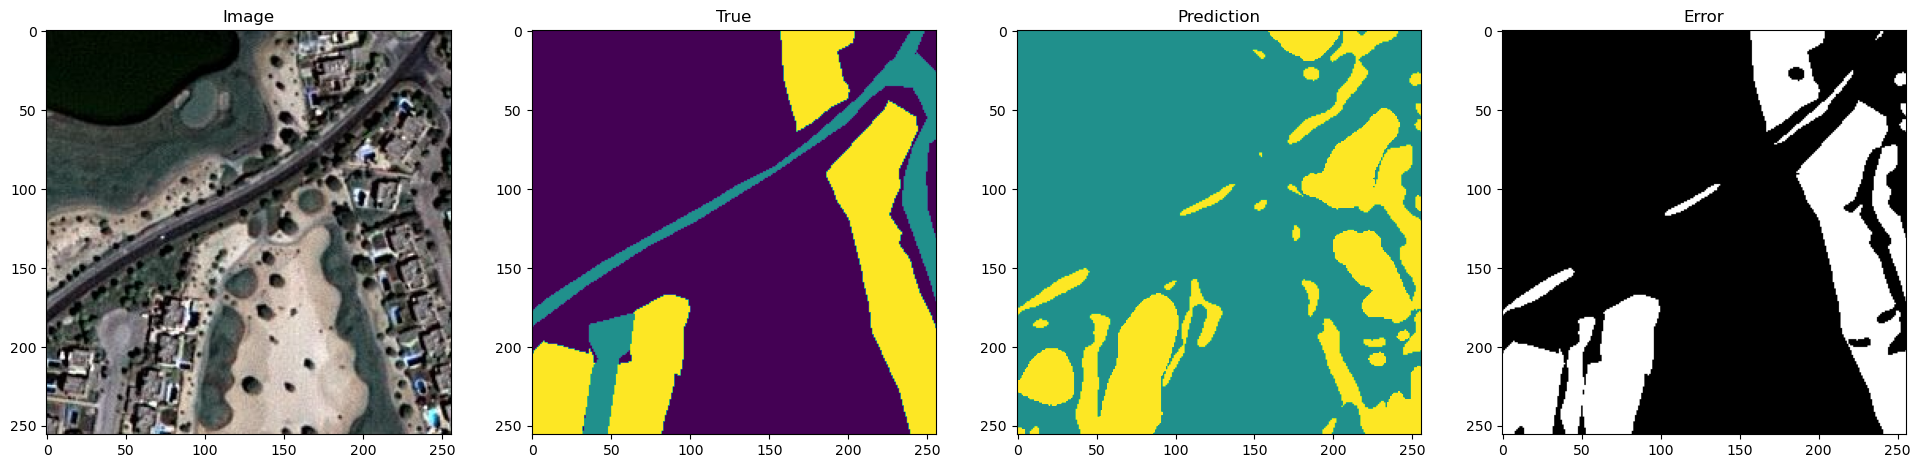

1/1 [==============================] - 0s 83ms/step


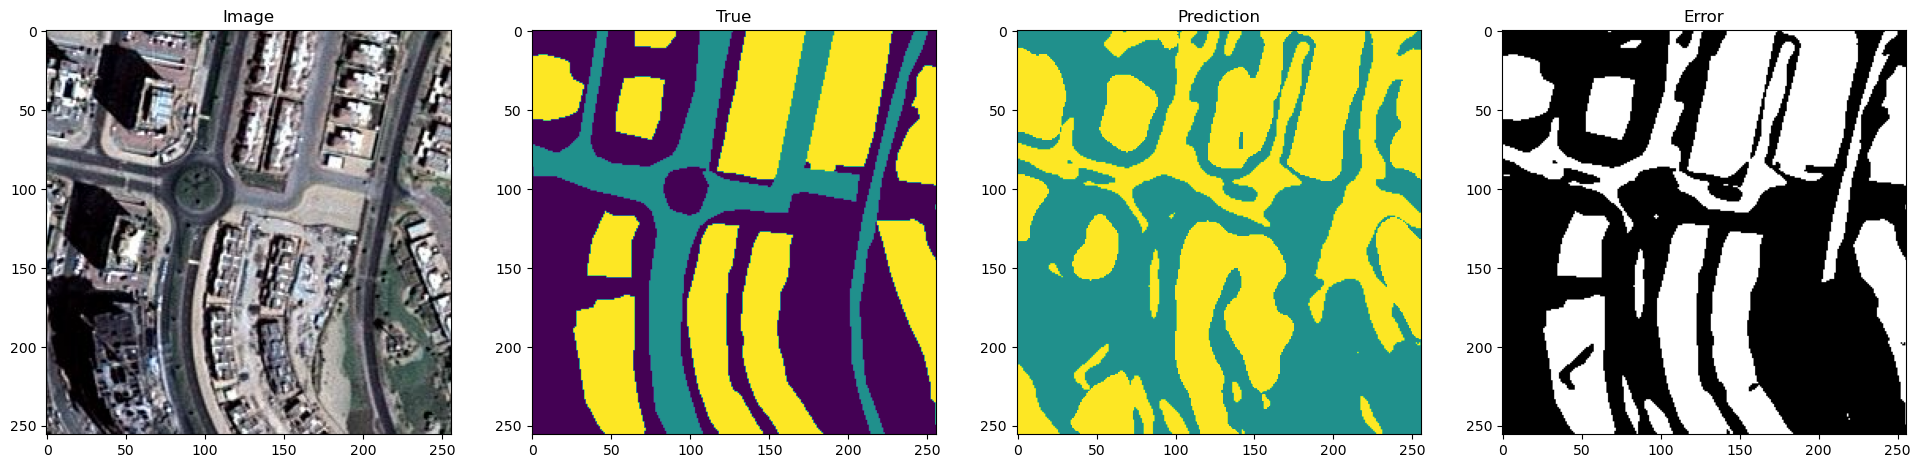

1/1 [==============================] - 0s 44ms/step


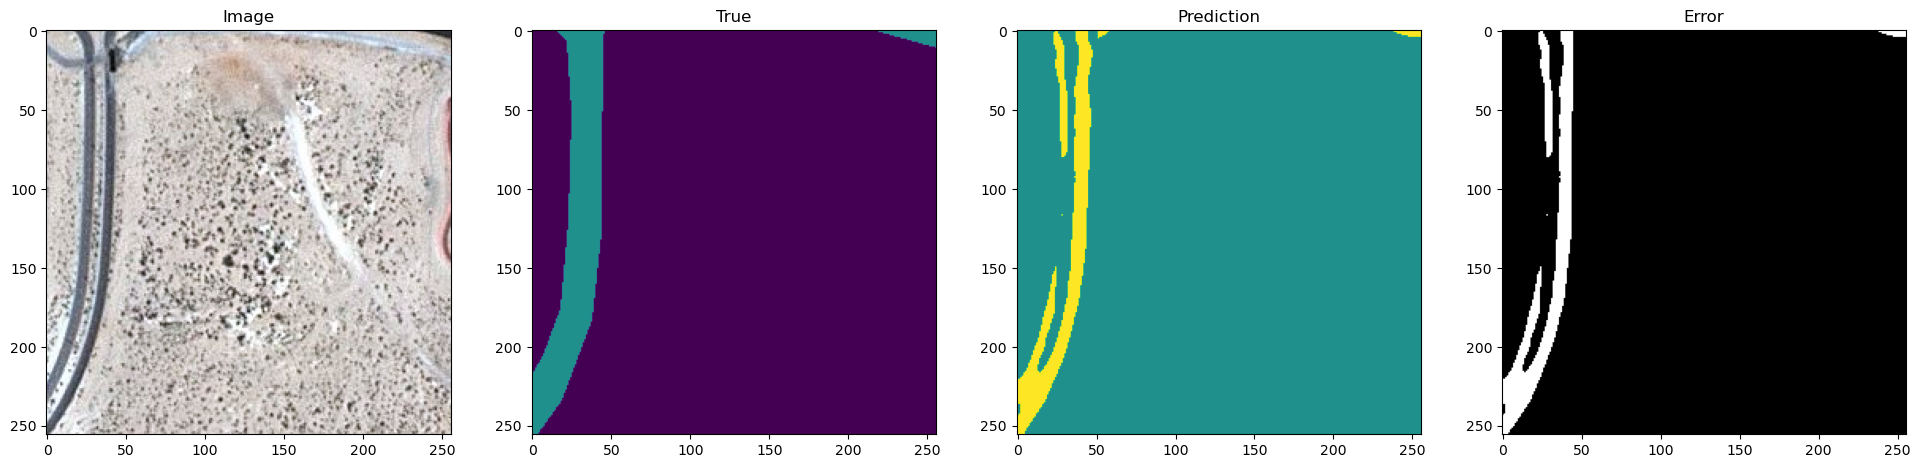

1/1 [==============================] - 0s 44ms/step


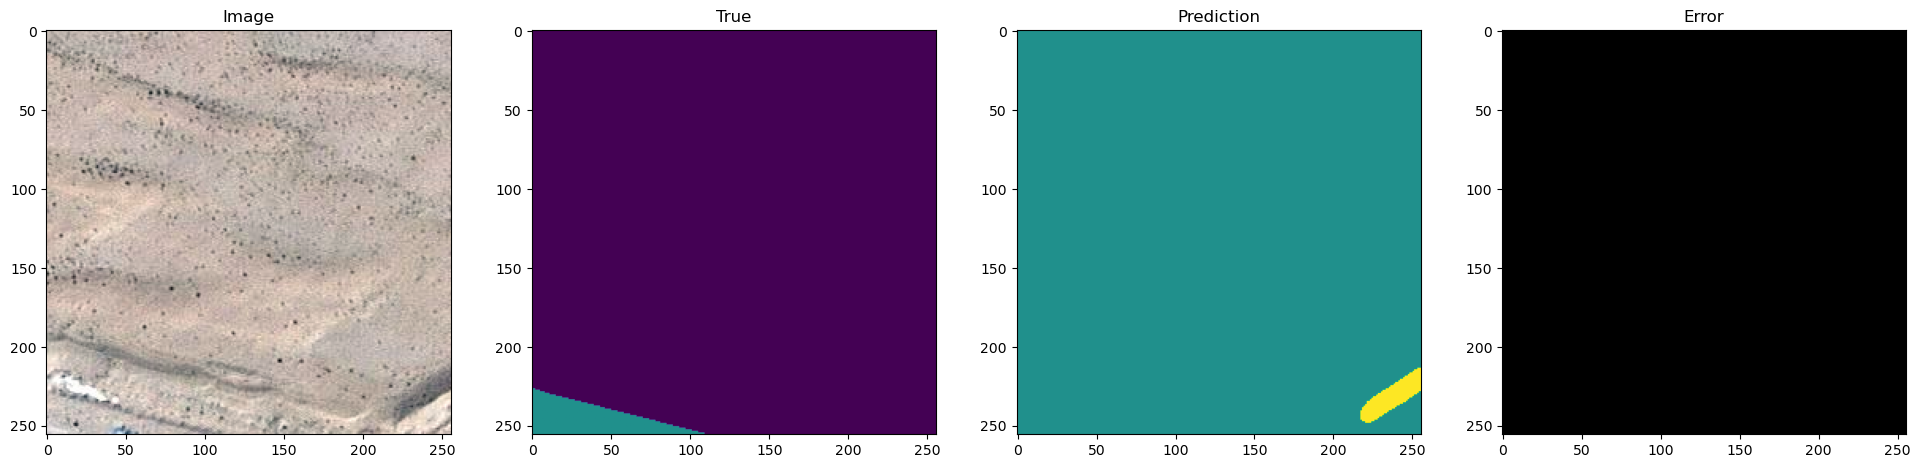

In [36]:
vmin = 0
vmax = 2

for i in range(5):
    
    image_number = random.randint(0, X_test.shape[0])
    
    plt.figure(figsize=(24, 6))
    
    plt.subplot(141)
    plt.title('Image')
    plt.imshow(X_test[image_number])
    
    plt.subplot(142)
    plt.title('True')
    true = y_test[image_number].argmax(axis=2)
    plt.imshow(true, vmin = vmin, vmax = vmax)
    
    plt.subplot(143)
    plt.title('Prediction')
    prediction = model.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2) + 1 # convert to 0-5 classes
    plt.imshow(prediction, vmin = vmin, vmax = vmax)
    
    plt.subplot(144)
    plt.title('Error')
    error = (true != prediction) & (true != 0)
    error = error.astype(int)
    plt.imshow(error, cmap='gray')
    
    plt.show()

In [37]:


# Evaluate the model
loss, iou_score, accuracy_score = model.evaluate(X_test, y_test)

print("Test Loss:", loss)
print("IoU Score:", iou_score)


3/3 [==============================] - 0s 83ms/step - loss: 0.9313 - accuracy: 0.8695 - mean_io_u_1: 0.5438
Test Loss: 0.9313451051712036
IoU Score: 0.8694694638252258
